In [1]:
#Important libraries are imported for processing and working with data. Stock A data is not sorted.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cointanalysis import CointAnalysis
from statsmodels.tsa.stattools import adfuller


#Seperate test CSV's are loaded with stock data
A = pd.read_csv("dataset_instrument_A.csv")
B = pd.read_csv("dataset_instrument_B.csv")

#sorted according to time
A = A.sort_values(by=['Time'], ascending=True)

In [2]:
A.info()
B.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96465 entries, 43368 to 32825
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Hour         96465 non-null  int64  
 1   Minute       96465 non-null  int64  
 2   Second       96465 non-null  int64  
 3   Millisecond  96465 non-null  int64  
 4   Time         96465 non-null  object 
 5   Price        96465 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 5.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96202 entries, 0 to 96201
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Hour         96202 non-null  int64  
 1   Minute       96202 non-null  int64  
 2   Second       96202 non-null  int64  
 3   Millisecond  96202 non-null  int64  
 4   Time         96202 non-null  object 
 5   Price        96183 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory

#### Clean the data

<Figure size 1152x288 with 0 Axes>

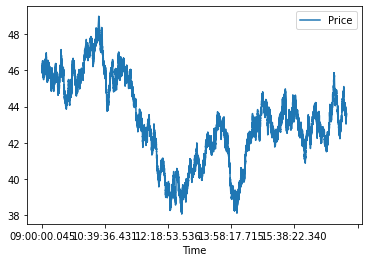

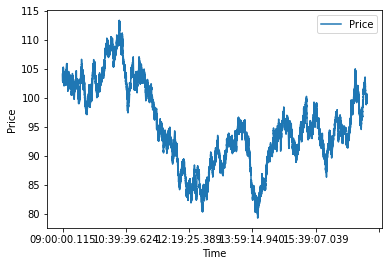

In [14]:
#remove nan and reset index
# Missing rows can be filled in by extrapolation, averaging,..
# In this case, only 19 rows were removed from B (19/96202) which is <0.019% of the data. And since the data density is high, this does not pose a problem

#A_null = A.isnull().sum()
#print(A_null)

#B_null = B.isnull().sum()
#print(B_null)

A = A.dropna() 
A.reset_index(drop=True)
B = B.dropna()
B.reset_index(drop=True)

#A.info()
#B.info()


#remove outliers in B (currently using SD, can also use ML)
mean = B["Price"].mean()
sd = B["Price"].std()
B = B[(B["Price"] <= mean+(3*sd))]
B = B[(B["Price"] >= mean-(3*sd))]

plt.figure(figsize=(16, 4))
A.plot(x = "Time", y = "Price")
B.plot(x = "Time", y = "Price")
plt.ylabel('Price')
plt.xlabel('Time')
plt.show()

#Once outliers are removed A and B look identical

In [4]:
#Resampling is needed for better visualisation of the plots in such high density data.
A_time = pd.read_csv(
    'dataset_instrument_A.csv', 
    parse_dates=['Time'], 
    index_col=['Time']
)

B_time = pd.read_csv(
    'dataset_instrument_B.csv', 
    parse_dates=['Time'], 
    index_col=['Time']
)

#remove outliers (currently using SD)
mean = B_time["Price"].mean()
sd = B_time["Price"].std()
B_time = B_time[(B_time["Price"] <= mean+(3*sd))]
B_time = B_time[(B_time["Price"] >= mean-(3*sd))]

# ~30 sec resampling
A_1hour = A_time["Price"].resample('0.01H').agg(['min','max', 'mean'])
B_1hour = B_time["Price"].resample('0.01H').agg(['min','max', 'mean'])

print(A_1hour)
print(B_1hour)

                       min    max       mean
Time                                        
2022-09-12 09:00:00  45.84  46.30  46.057869
2022-09-12 09:00:36  46.09  46.53  46.356111
2022-09-12 09:01:12  45.64  46.51  46.144831
2022-09-12 09:01:48  45.50  46.04  45.744876
2022-09-12 09:02:24  45.49  46.05  45.818871
...                    ...    ...        ...
2022-09-12 16:57:00  43.53  43.90  43.716250
2022-09-12 16:57:36  43.53  44.22  43.909483
2022-09-12 16:58:12  43.56  44.01  43.820813
2022-09-12 16:58:48  43.04  43.61  43.264530
2022-09-12 16:59:24  43.04  43.63  43.412759

[800 rows x 3 columns]
                         min      max        mean
Time                                             
2022-09-12 09:00:00  102.675  104.219  103.457704
2022-09-12 09:00:36  103.100  105.159  104.406504
2022-09-12 09:01:12  102.517  105.319  104.057222
2022-09-12 09:01:48  102.067  103.763  102.817664
2022-09-12 09:02:24  102.454  103.825  103.154717
...                      ...      ...    

<AxesSubplot:xlabel='Time'>

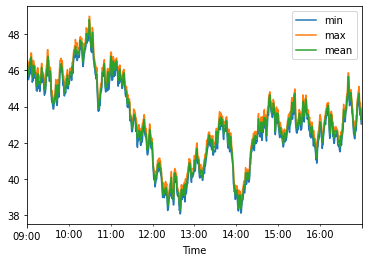

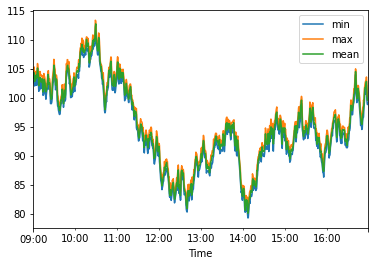

In [5]:
#The hourly sampled plot shows that the pricce is highest during morning and drops to its lowest around midday after which it recovers.
A_1hour.plot()
B_1hour.plot()

In [6]:
A_1hour['max'].corr(B_1hour['max'])

#A correlation index of ~0.005 is received when stock A data and stock B are directly compared. This indicates an extremely low linear relation.
#However, when the resampled data sets are compared they give an extremely high correrlation which indicates that the data can be used for modelling. 

0.9810807475786718

In [7]:
X = np.array([A_1hour['max'], B_1hour['max']]).T
coint = CointAnalysis()
coint.test(X)
print(coint.pvalue_)

coint.fit(X)
print(f'coef: {coint.coef_}')
print(f'mean: {coint.mean_}')

print(f'std: {coint.std_}')

# Since p value is greater than 0.05 for both A and B this suggests that data is non-stationary

0.5722152085186427
coef: [-2.97491424  1.        ]
mean: -33.21936590467982
std: 1.36072202564486


In [8]:
# this involves removing the trend from the data series to make it stationary.  
# A differencing technique is effective  in this case
df = pd.DataFrame(X, columns = ['A','B'])

df = df.diff()

df = df.iloc[1:,:]

df['Stat'] = df['A'] * df['B']

df = df.dropna()
df.reset_index(drop=True)

,A,B,Stat
0,0.23,0.940,0.21620
1,-0.02,0.160,-0.00320
2,-0.47,-1.556,0.73132
3,0.01,0.062,0.00062
4,0.12,0.047,0.00564
...,...,...,...
794,-0.54,0.611,-0.32994
795,0.32,-1.045,-0.33440
796,-0.21,-2.270,0.47670
797,-0.40,0.110,-0.04400


P-value is 1.7213351378721132e-05


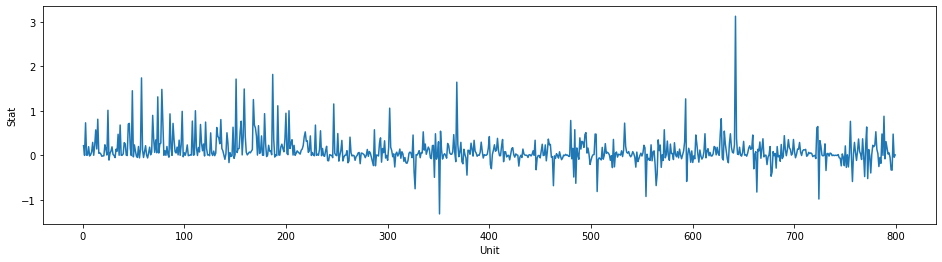

In [9]:
plt.figure(figsize=(16, 4))
plt.ylabel('Stat')
plt.xlabel('Unit')
df['Stat'].plot()

print("P-value is",adfuller(df['Stat'])[1]) #rejects null hypothesis and can be used for modelling

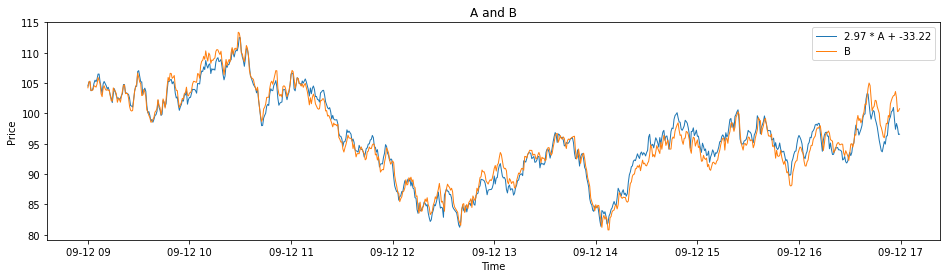

In [10]:
coint.fit(X)

plt.figure(figsize=(16, 4))
A_theo = (-coint.coef_[0]) * A_1hour['max'] + coint.mean_

plt.title('A and B')
plt.plot(A_theo, label=f'{-coint.coef_[0]:.2f} * A + {coint.mean_:.2f}', linewidth=1)
plt.plot(B_1hour['max'], label='B', linewidth=1)
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

# A can be adjusted with cointegration parameters and this follows in line with B.

559.3


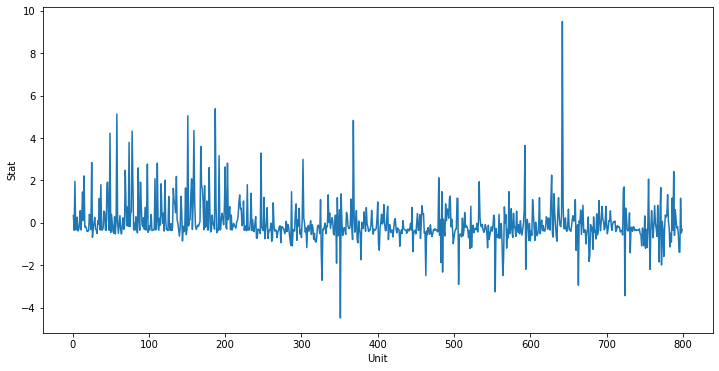

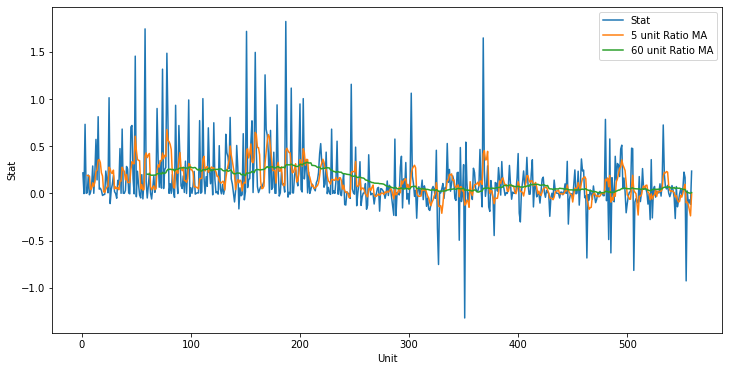

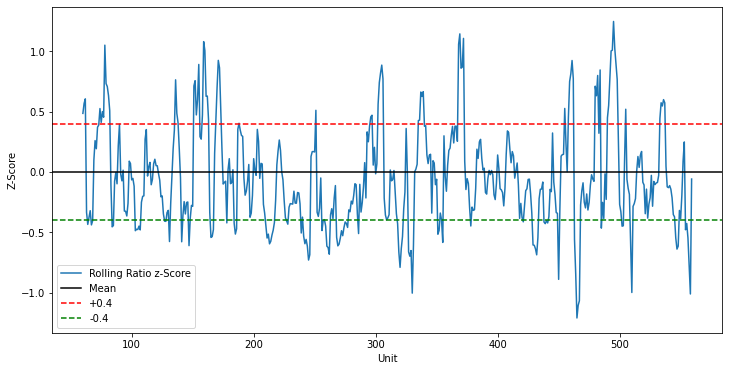

In [11]:
# Standardization assuming the spread
plt.figure(figsize=(12,6))
plt.ylabel('Stat')
plt.xlabel('Unit')
Ratio_mean = df['Stat'].mean()
# Calculating Standard deviation
Ratio_std = df['Stat'].std()
# Standardizing
df['stand'] = (df['Stat'] - Ratio_mean) / Ratio_std
df['stand'].plot()


# Dividing into training and testing set for modelling purposes
print(len(df['Stat']) * .70 ) 
train = df['Stat'][:559]
test = df['Stat'][559:]



ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Stat', '5 unit Ratio MA', '60 unit Ratio MA'])
plt.ylabel('Stat')
plt.xlabel('Unit')
plt.show()


plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(0.4, color='red', linestyle='--')
plt.axhline(-0.4, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+0.4', '-0.4'])
plt.ylabel('Z-Score')
plt.xlabel('Unit')
plt.show()

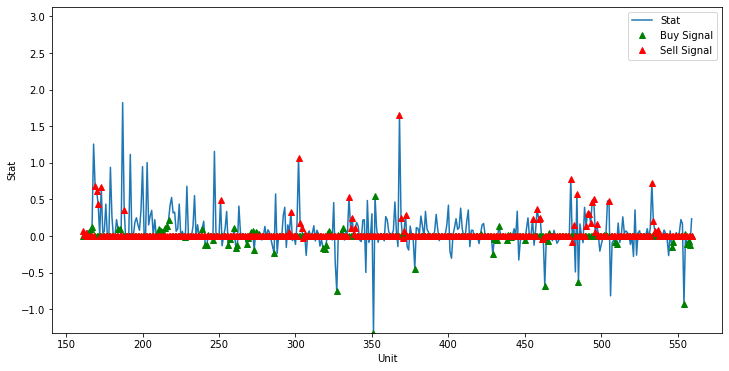

In [12]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-0.4] = 0
sell[zscore_60_5<0.4] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, df['Stat'].min(), df['Stat'].max()))
plt.ylabel('Stat')
plt.xlabel('Unit')
plt.legend(['Stat', 'Buy Signal', 'Sell Signal'])
plt.show()

In [13]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    stat = S1/S2
    ma1 = stat.rolling(window=window1,
                               center=False).mean()
    ma2 = stat.rolling(window=window2,
                               center=False).mean()
    std = stat.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with 1 Euro and no positions
    money = 1
    countS1 = 0
    countS2 = 0
    for i in range(len(stat)):
        # Sell short if the z-score is > 0.4
        if zscore[i] < -0.4:
            money += S1[i] - S2[i] * stat[i]
            countS1 -= 1
            countS2 += stat[i]
            #print('Selling  %s %s %s %s'%(money, stat[i], countS1,countS2))
        # Buy long if the z-score is < -0.4
        elif zscore[i] > 0.4:
            money -= S1[i] - S2[i] * stat[i]
            countS1 += 1
            countS2 -= stat[i]
            #print('Buying %s %s %s %s'%(money,stat[i], countS1,countS2))
        # Clear positions if the z-score between -.35 and .35
        elif abs(zscore[i]) < 0.35:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,stat[i], countS1,countS2))
            
            
    return money

print("Money made using current pairs trading model from 1 Euro is", int(trade(A_1hour['max'].iloc[10:], B_1hour['max'].iloc[10:], 80, 2)),"Euros")

Money made using current pairs trading model from 1 Euro is 267 Euros
